Graph cleaning
==============

Good sources of street network data, such as the Ordnance Survey's [OS Open Roads](https://www.ordnancesurvey.co.uk/business-and-government/products/os-open-roads.html), typically have two distinguishing characteristics:
- The network has been simplified to its essential structure: i.e. unnecessarily complex representations of intersections; on-ramps; split roadways; etc. have been reduced to a simpler representation concurring more readily with the core topological structure of street networks. This is in contrast to network representations focusing on completeness (e.g. for route way-finding, see [OS ITN Layer](https://www.ordnancesurvey.co.uk/business-and-government/help-and-support/products/itn-layer.html)): these introduce unnecessary complexity serving to hinder rather than help shortest-path algorithms.
- The topology of the network is kept distinct from the geometry of the streets. Oftentimes, as can be seen with [Open Street Map](https://www.openstreetmap.org), additional nodes are added to streets for the purpose of representing geometric twists and turns along a roadway. These additional nodes cause topological distortions that impact network centrality measures.

When a high-quality source is available, it may be best not to attempt additional cleanup unless there is a particular reason to do so. On the other-hand, many indispensable sources of network information, particularly Open Street Map data, can be messy for the purposes of network analysis. This section describes how such sources can be cleaned and prepared for subsequent analysis.


Downloading data
----------------

This example will make use of OSM data downloaded from the [OSM API](https://wiki.openstreetmap.org/wiki/API). To keep things interesting, let's pick Travalgar Square in London, which will be buffered and cleaned for a $1,600m$ radius.

The following example makes use of two excellent python modules: [`utm`](https://github.com/Turbo87/utm) for converting between `WGS` geographic coordinates and `UTM` projected coordinates; and [`shapely`](https://github.com/Toblerity/Shapely) for generating and manipulating geometry.

In [9]:
import requests
import utm
from shapely import geometry

# let's download data within a 1,600m buffer around Travalgar Square in London:
lat, lng = (51.507999, -0.127970)
# cast the WGS coordinates to UTM prior to buffering
easting, northing, utm_zone_number, utm_zone_letter = utm.from_latlon(lat, lng) 
# create a point, and then buffer
pt = geometry.Point(easting, northing)
geom_utm = pt.buffer(1600)
# cast the geometry back to WGS for the OSM query
geom_wgs = [utm.to_latlon(e, n, utm_zone_number, utm_zone_letter) for e, n in geom_utm.exterior.coords]
# format for OSM query
geom_osm = str.join(' ', [f'{lat} {lng}' for lat, lng in geom_wgs])
# osm query
timeout = 10
filters = '["area"!~"yes"]' \
          '["highway"!~"path|footway|motor|proposed|construction|abandoned|platform|raceway|service"]' \
          '["foot"!~"no"]' \
          '["service"!~"private"]' \
          '["access"!~"private"]'
query = f'[out:json][timeout:{timeout}];(way["highway"]{filters}(poly:"{geom_osm}"); >;);out skel qt;'
try:
    response = requests.get('https://overpass-api.de/api/interpreter',
                            timeout=timeout,
                            params={
                                'data': query
                            })
except requests.exceptions.RequestException as e:
    raise e

You may want to experiment with the filtering applied to the OSM query. See the [OSM Overpass API](https://wiki.openstreetmap.org/wiki/Overpass_API) for more information.


Generating a graph
------------------

Once the data has been downloaded, `cityseer.util` can be used to load and subsequently clean the network. The graph should be converted from WGS to UTM coordinates prior to further processing.


INFO:cityseer.util.graphs:Converting networkX graph from WGS to UTM.
INFO:cityseer.util.graphs:Processing node x, y coordinates.


INFO:cityseer.util.graphs:Processing edge geom coordinates, if present.


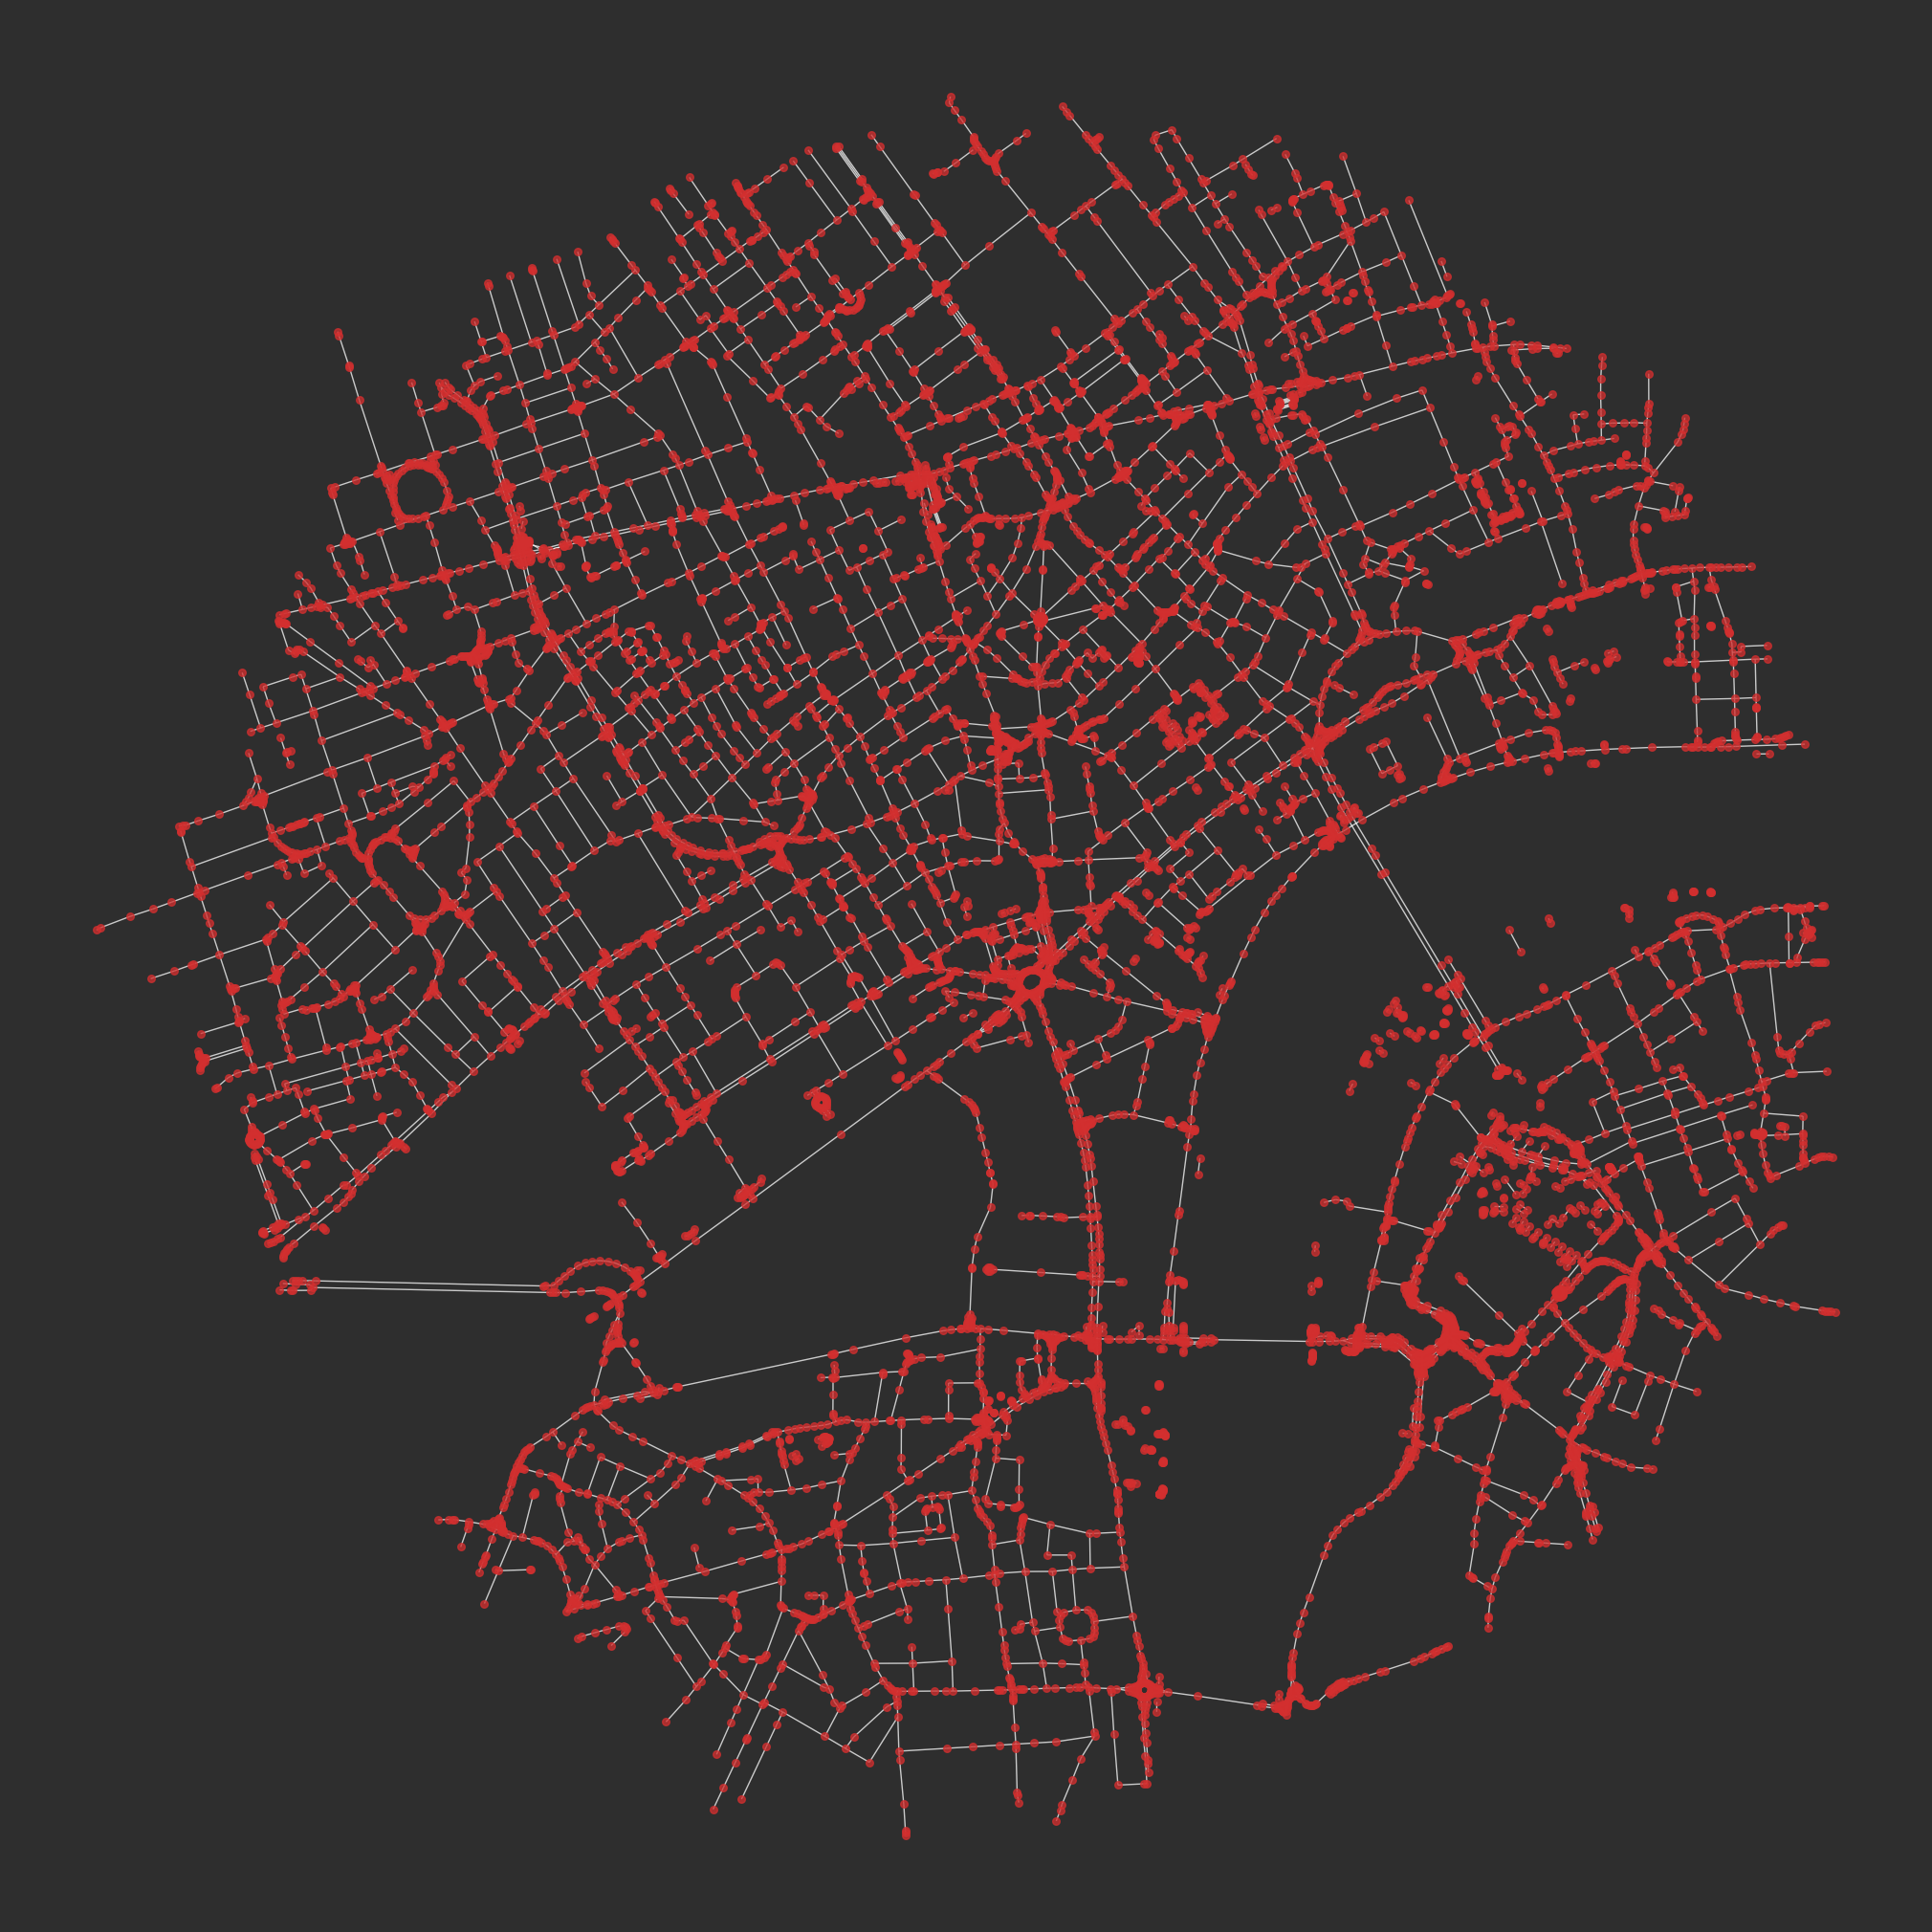

In [10]:
from cityseer.util import graphs, plot

# load the OSM response data into a networkX graph
G_wgs = graphs.nX_from_osm(osm_json=response.text)
# cast the graph to UTM coordinates prior to processing
G_utm = graphs.nX_wgs_to_utm(G_wgs)

plot.plot_nX(G_utm, figsize=(20, 20), dpi=100)

Deducing the network topology
-----------------------------

Now that raw OSM data has been loaded into a NetworkX graph, the `cityseer.util.graph` methods can be used to further clean and prepare the network prior to analysis.

At this stage, the raw OSM graph is going to look a bit messy. Note how that nodes have been used to represent the roadway geometry. These nodes need to be removed and will be abstracted into `shapely` `LineString` geometries assigned to the respective street edges. So doing, the geometric representation will be kept distinct from the network topology.

In [11]:
# the raw osm nodes denote the road geometries by the placement of nodes
# the first step will generate explicit linestring geometries for each street edge
G = graphs.nX_simple_geoms(G_utm)

INFO:cityseer.util.graphs:Generating simple (straight) edge geometries.


INFO:cityseer.util.graphs:Removing dangling nodes.


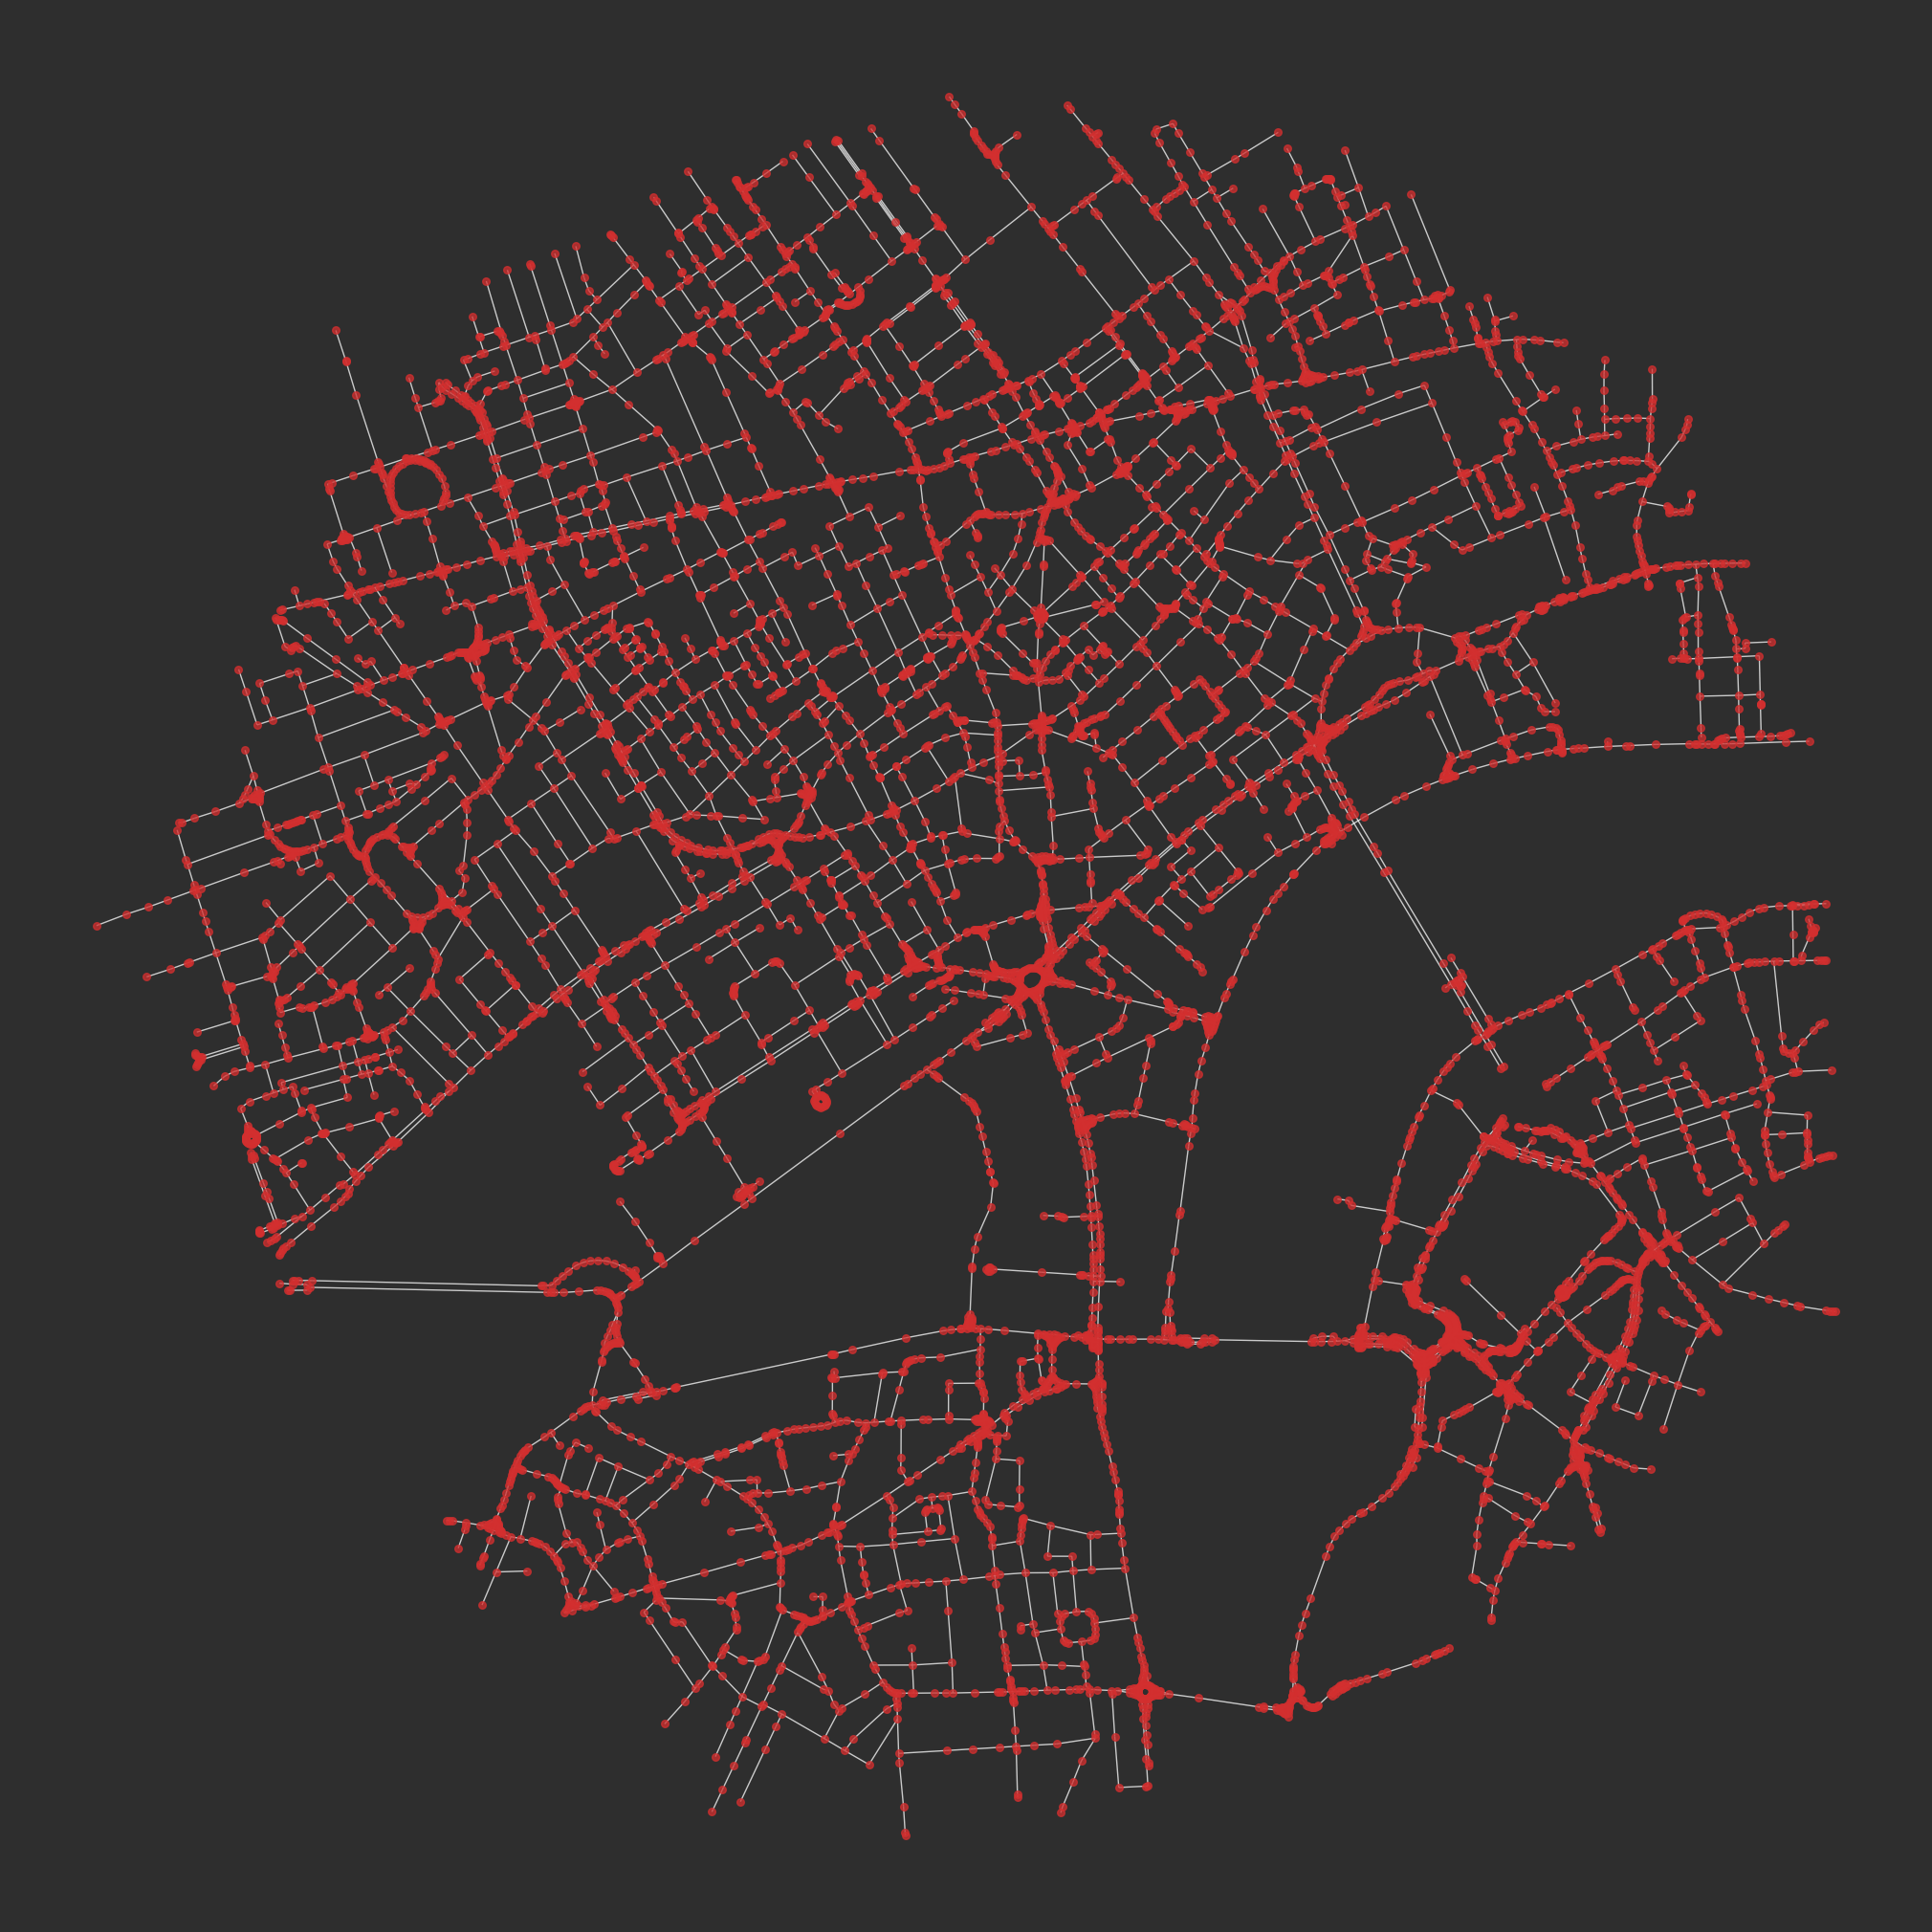

In [12]:
# OSM graphs will often have "stubs", e.g. at entrances to buildings or parking lots
# these will now be removed, and can be fine-tuned with the despine parameter.
# The removed_disconnected flag will removed isolated network components
# i.e. disconnected portions of network that are not joined to the main street network
G = graphs.nX_remove_dangling_nodes(G, despine=25, remove_disconnected=True)

plot.plot_nX(G, figsize=(20, 20), dpi=100)

INFO:cityseer.util.graphs:Removing filler nodes.


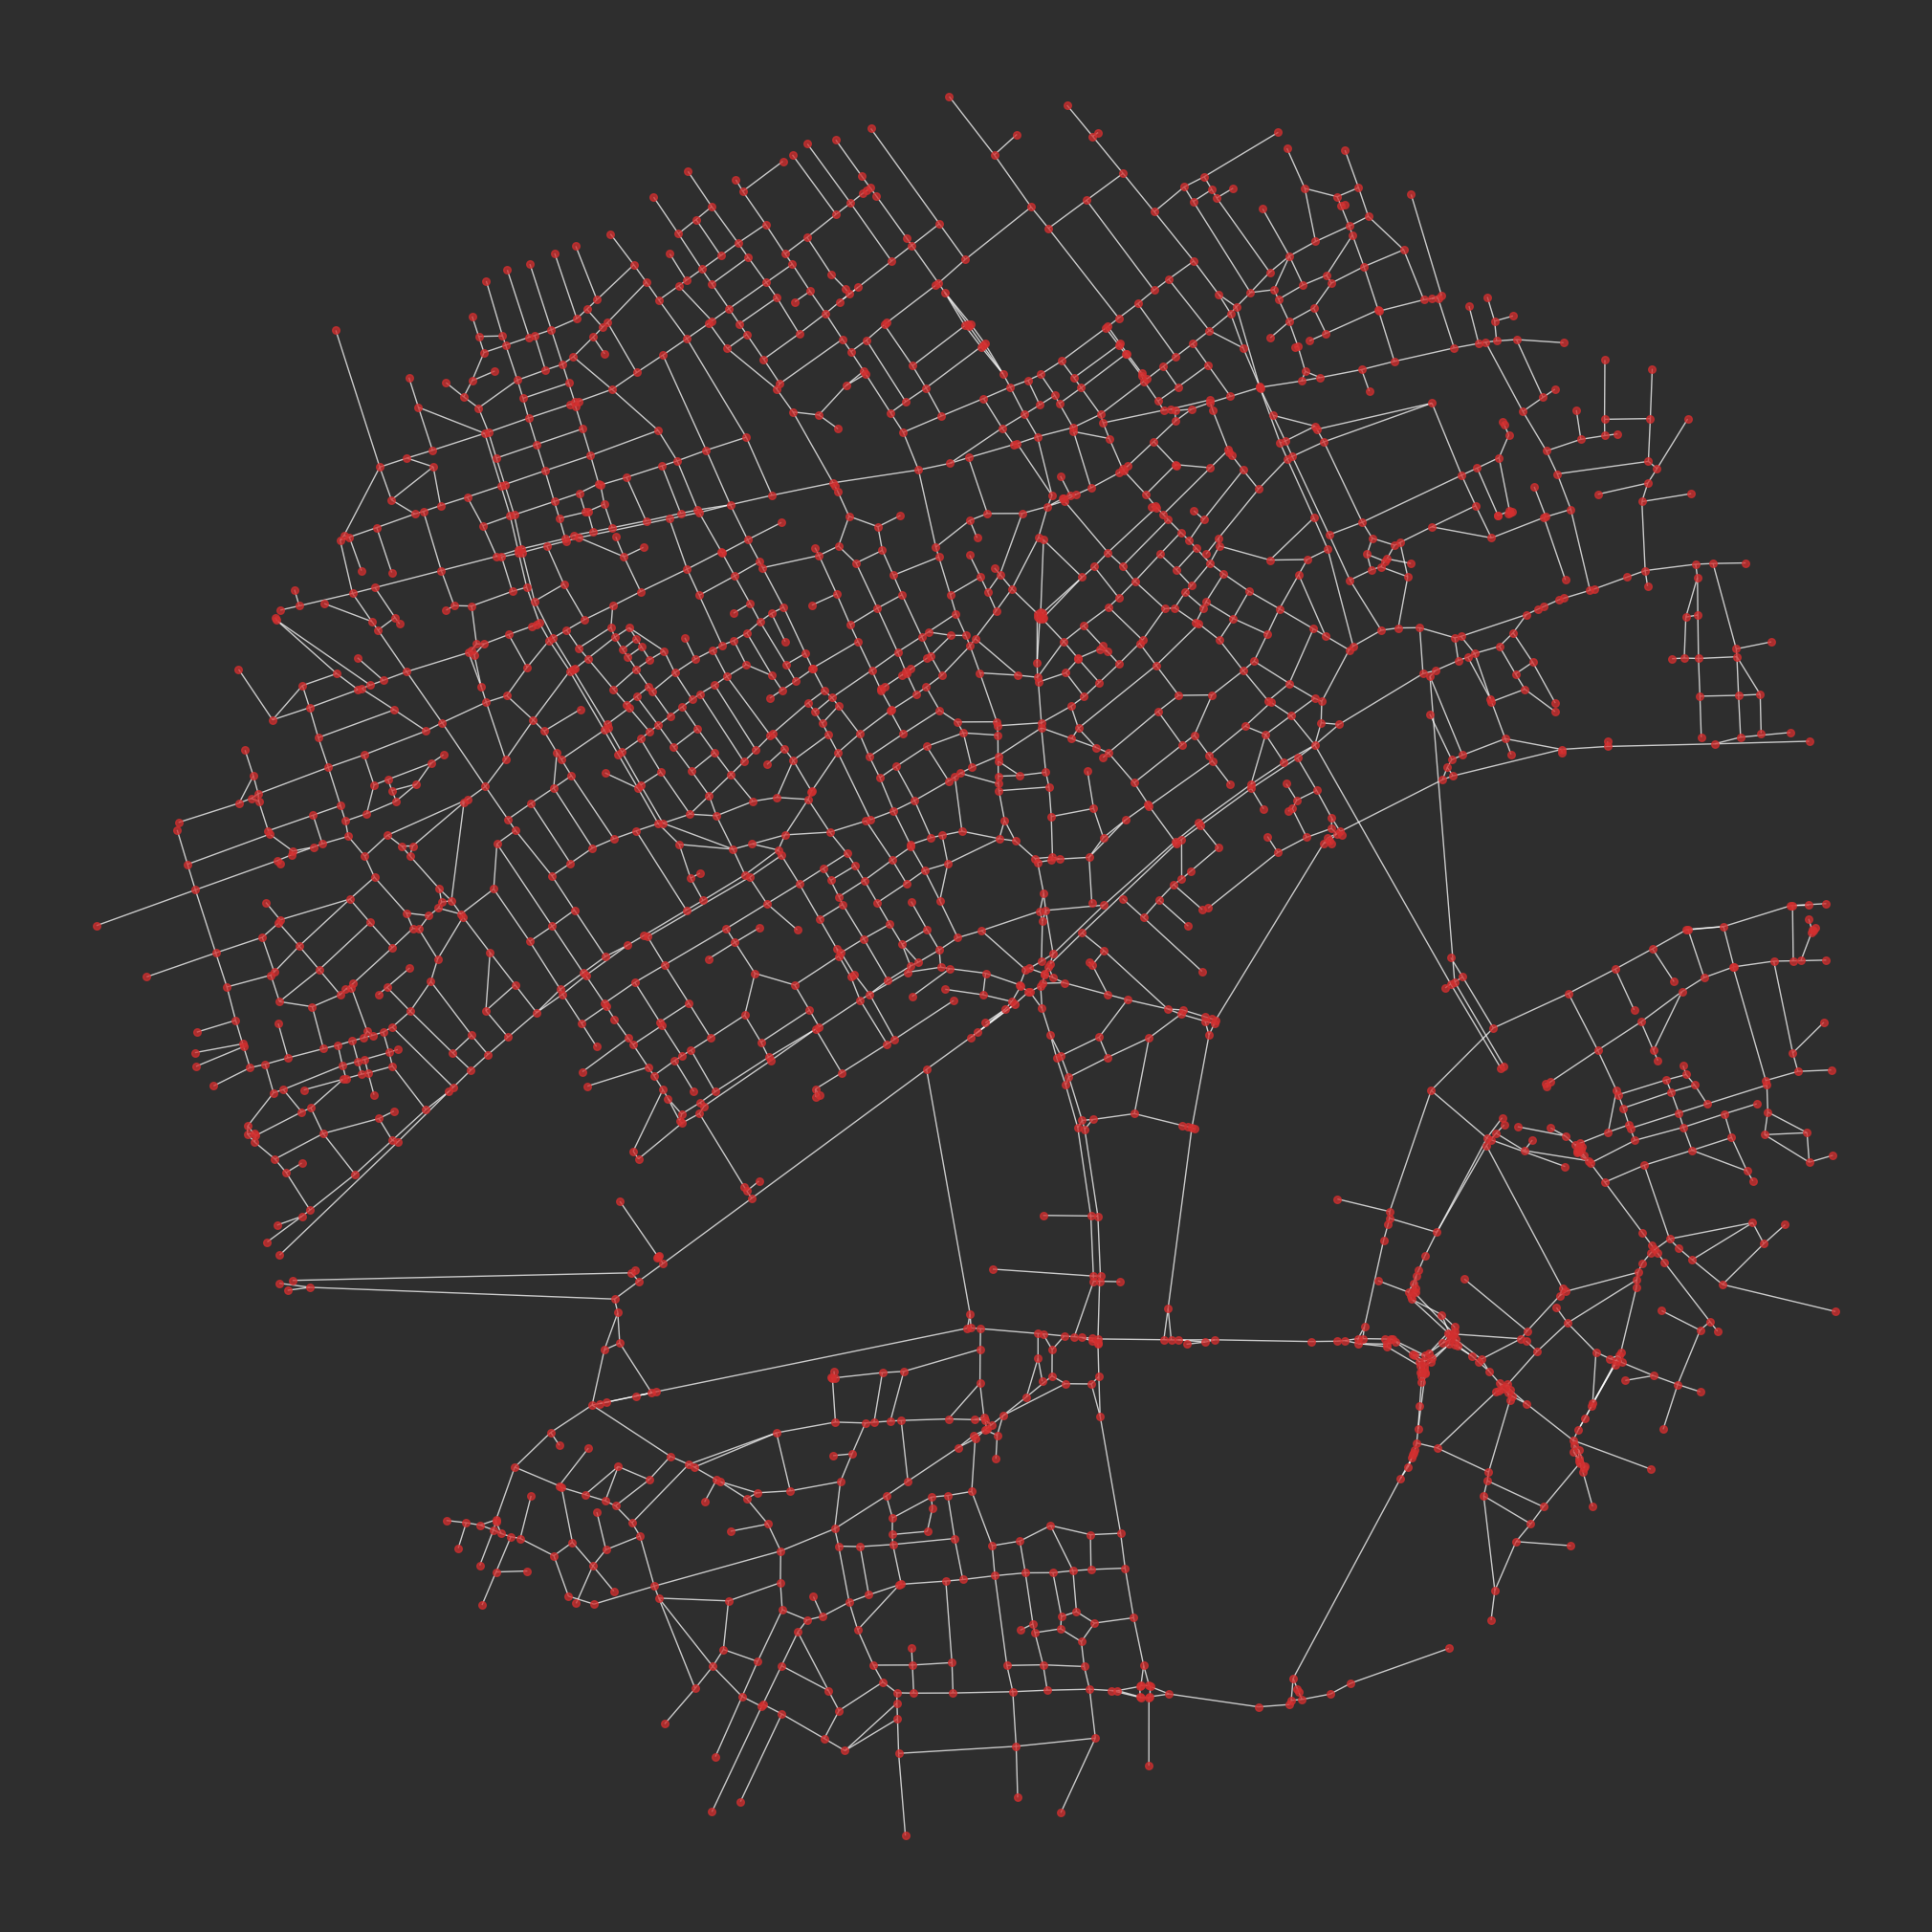

In [13]:
# We'll now strip the "filler-nodes" from the graph
# the associated geometries will be welded into continuous linestrings
# the new linestrings will be assigned to the newly consolidated topological links
G = graphs.nX_remove_filler_nodes(G)

plot.plot_nX(G, figsize=(20, 20), dpi=100)

At this point it may initially appear that the roadway geometries have now gone missing. However, this information is still present in the `LineString` geometries assigned to each street edge. Put differently, the plotted representation is now topological, not geometric. During conversion to a `cityseer` network map, `cityseer` will automatically compute the length and comulative angular change for each of these `LineString` geoms. The entry and exit angle of each network edge is also determined and is used internally to compute and aggregate angular change from one street to another.


Refining the network
--------------------

The final step involves the consolidation of nodes to clean-up extraneous nodes, which may otherwise exaggerate the intensity or complexity of the network in certain situations. 

Two different methods can be used for this purpose:
- [`X_consolidate_spatial`](https://cityseer.github.io/cityseer/util/graphs.html#nx-consolidate-spatial) consolidates adjacent nodes based on a crow-flies distance threshold;
- [nX_consolidate_parallel](https://cityseer.github.io/cityseer/util/graphs.html#nx-consolidate-parallel) consolidates adjacent nodes for parallel edges, and tends to give superior results.
Both methods take a `buffer_dist` parameter specifying the threshold distance at which to apply consolidation, and may involve a degree of experimentation to find suitable distance.

These methods can optionally be combined with network decomposition, which can be applied before or after, depending on which gives the best results for a given situation. 

INFO:cityseer.util.graphs:Consolidating network by distance buffer.


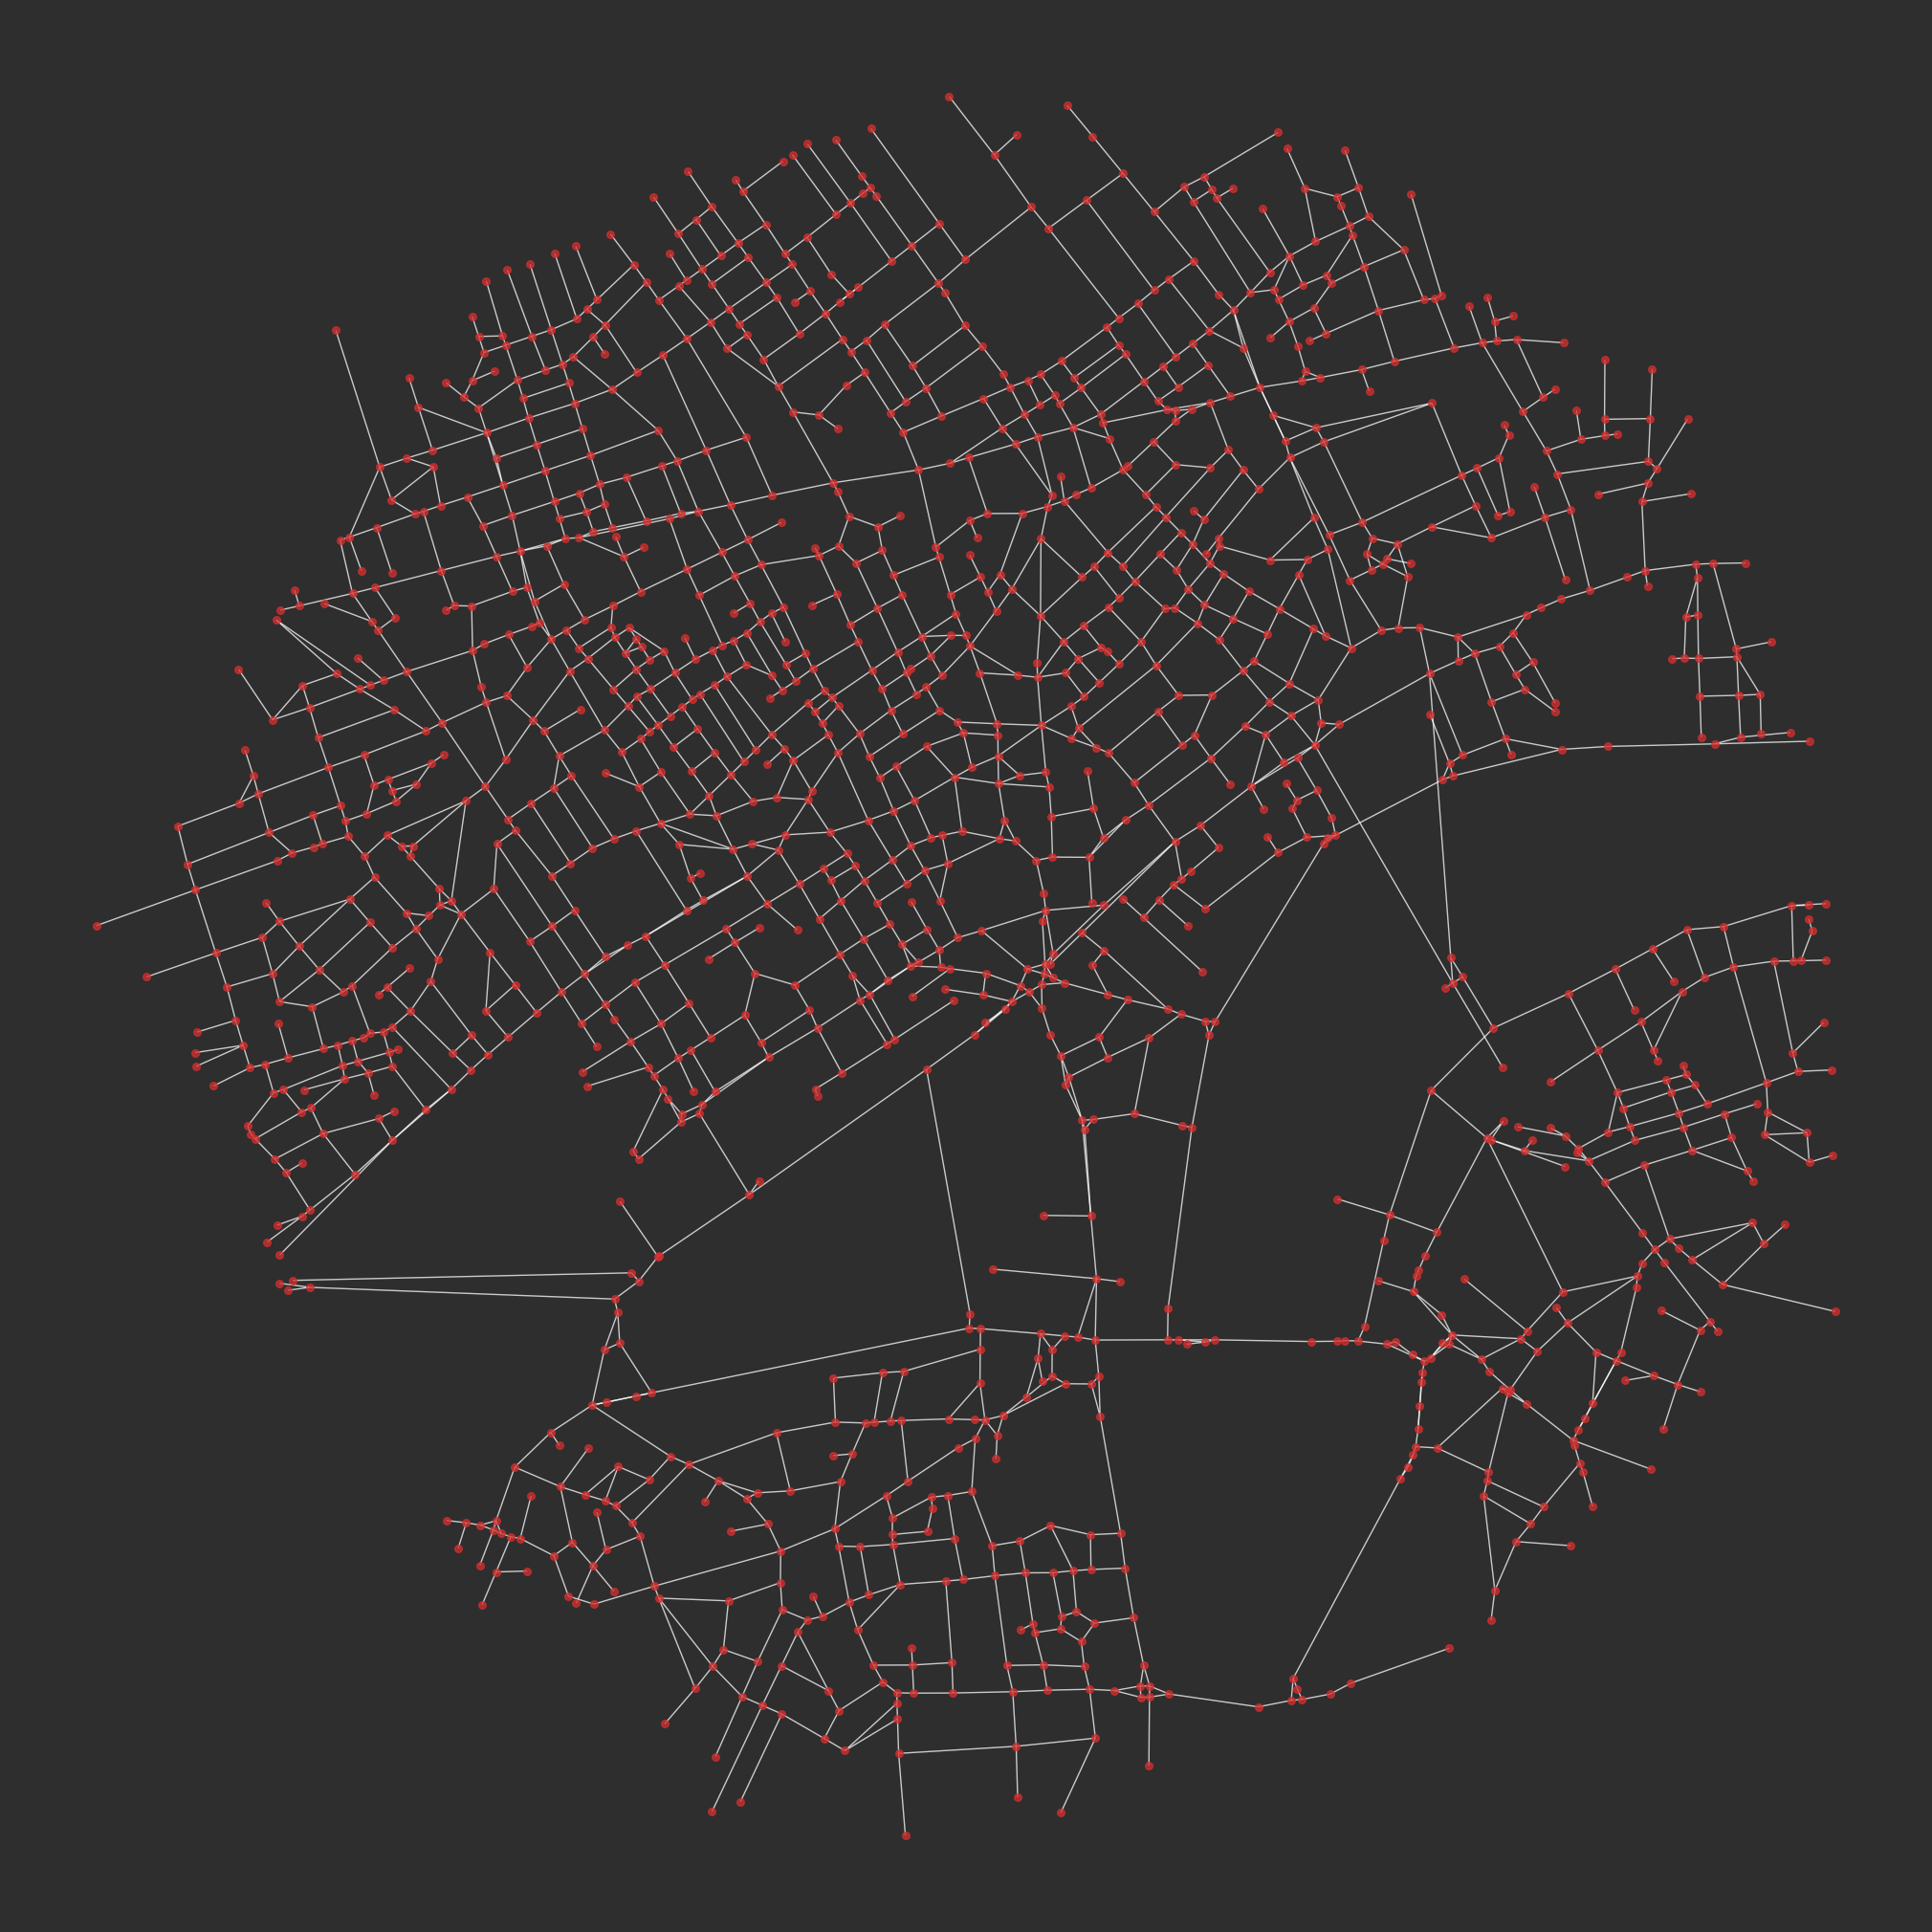

In [14]:
# some experimentation may be required to find the optimal buffer distance
# setting it too large, will deteriorate the quality of the network
G_ex = graphs.nX_consolidate_spatial(G, buffer_dist=15)

plot.plot_nX(G_ex, figsize=(20, 20), dpi=100)

INFO:cityseer.util.graphs:Consolidating network by parallel edges.


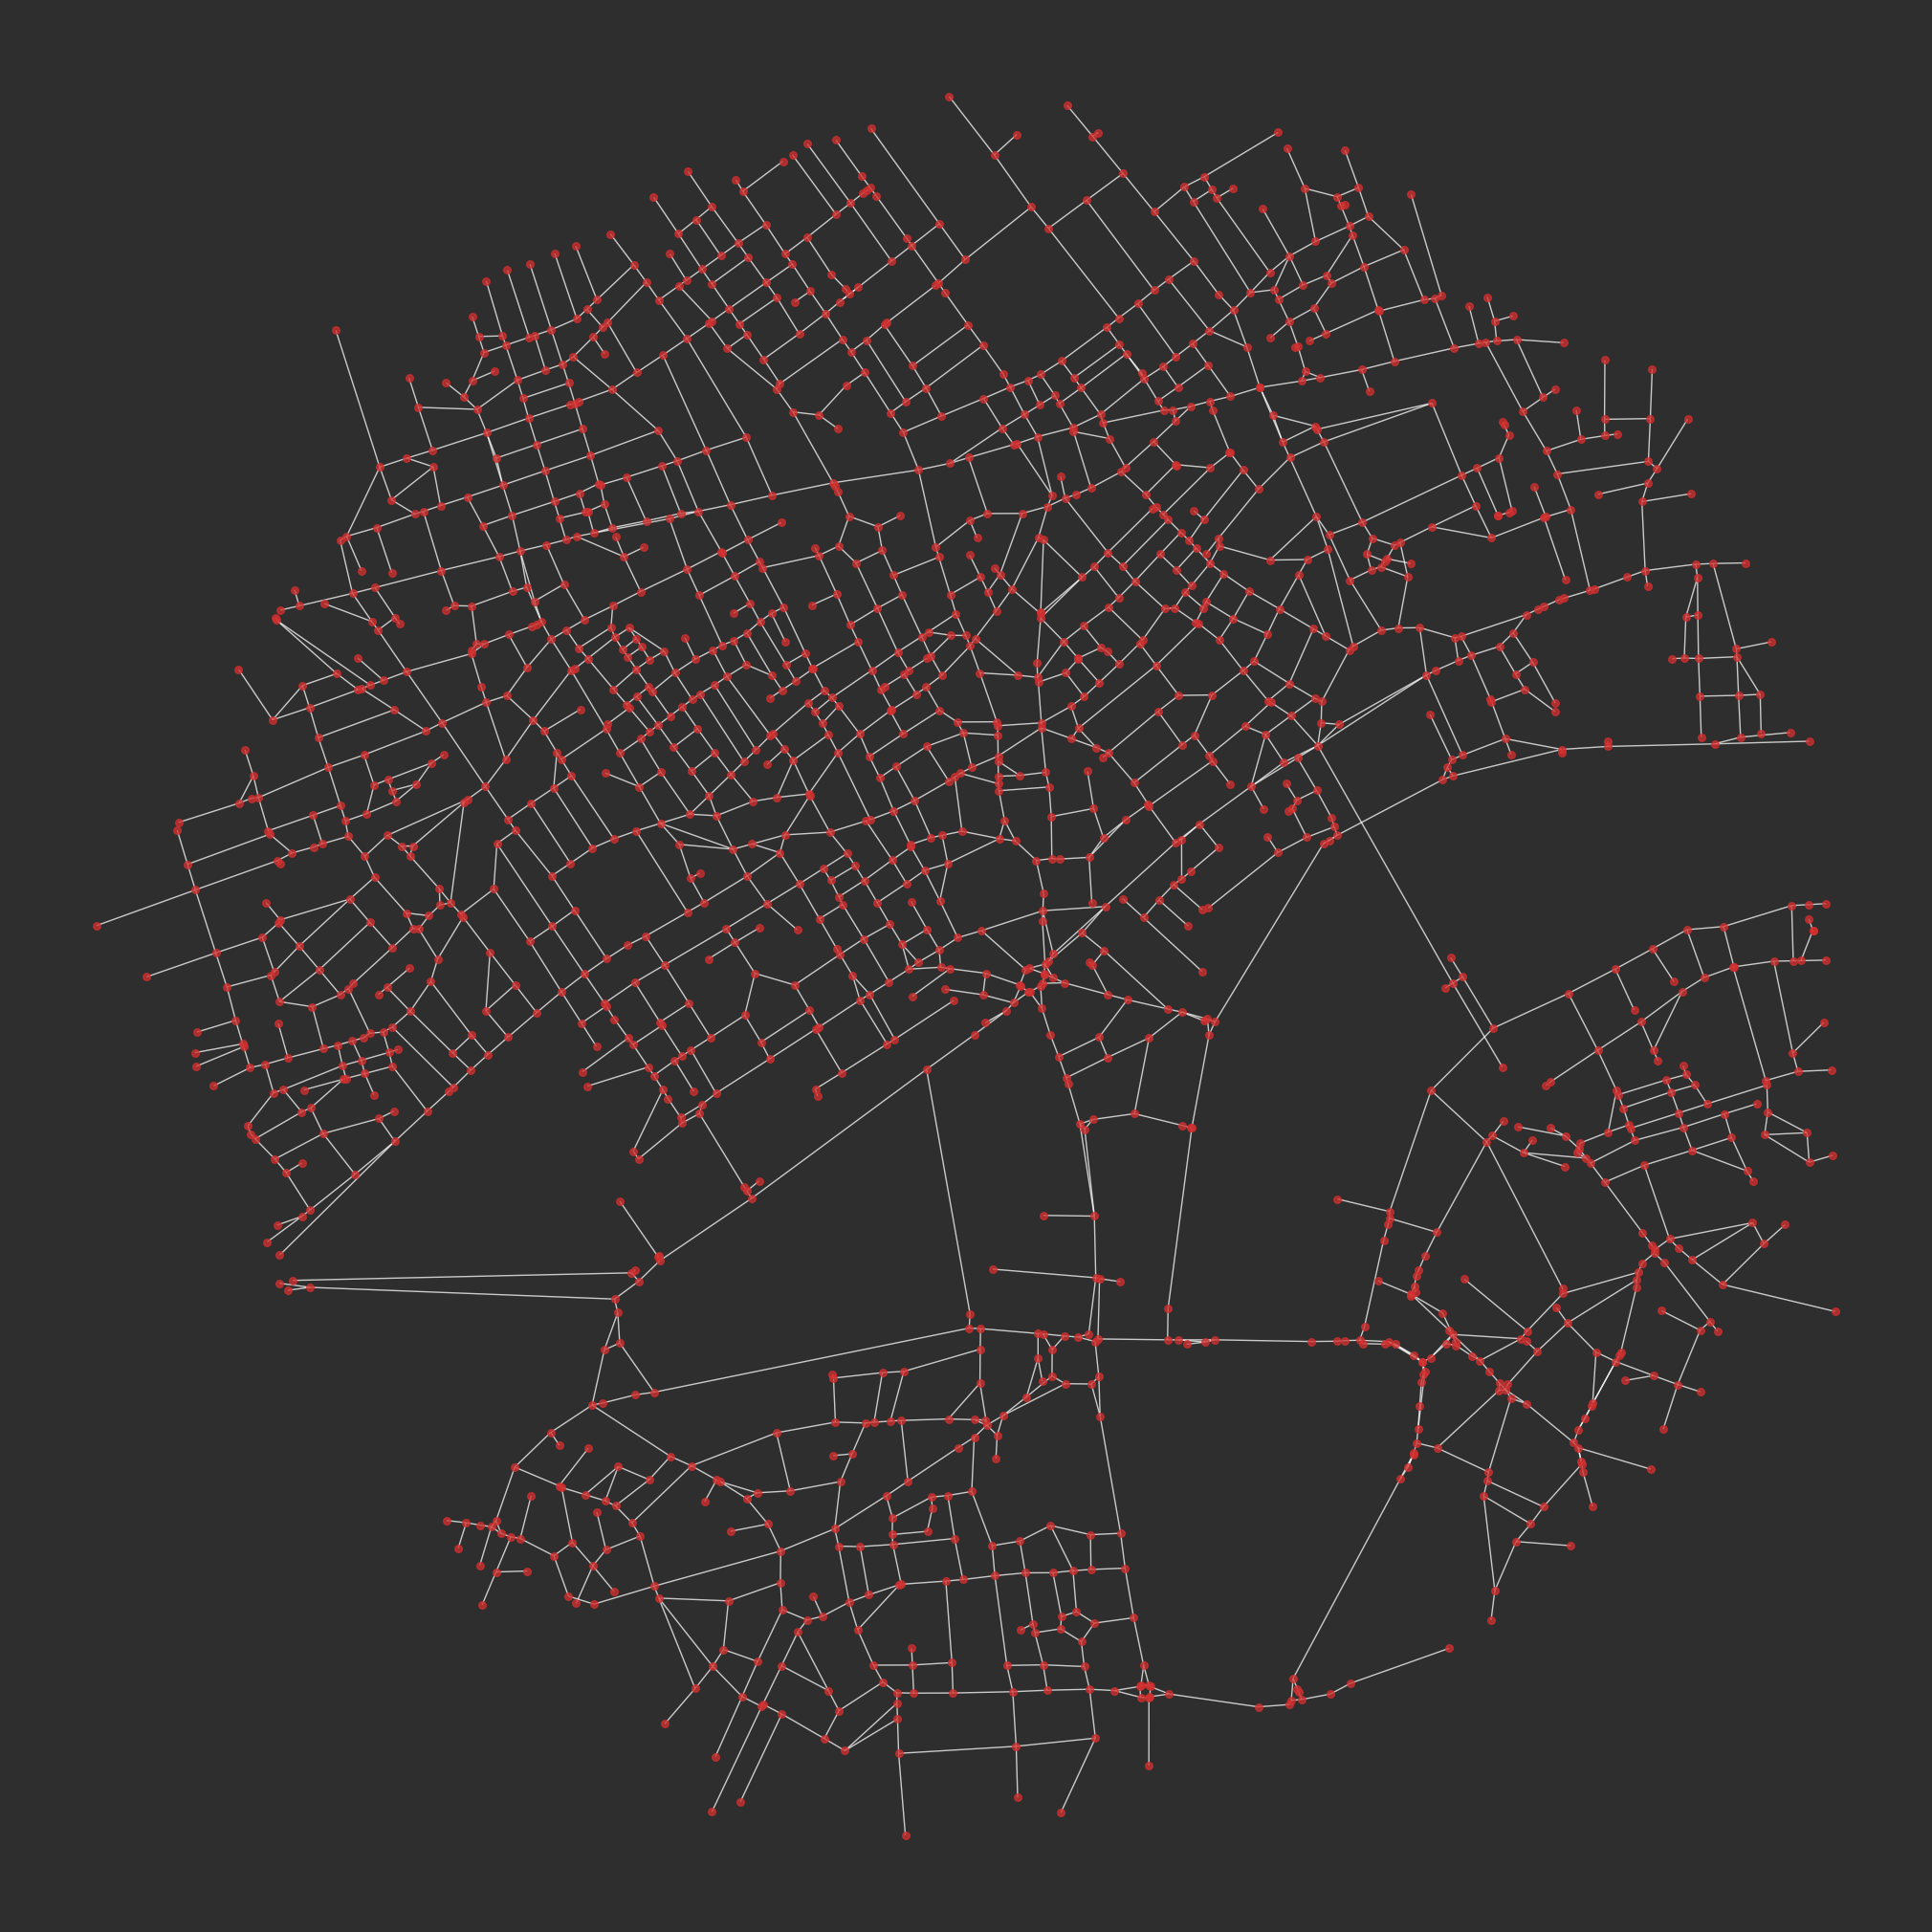

In [15]:
# here is an example with the parallel edges consolidation method
# note that granular street networks (e.g. Soho) now have better preserved topology
G_ex = graphs.nX_consolidate_parallel(G, buffer_dist=15)

plot.plot_nX(G_ex, figsize=(20, 20), dpi=100)

INFO:cityseer.util.graphs:Decomposing graph to maximum edge lengths of 50.


INFO:cityseer.util.graphs:Consolidating network by parallel edges.


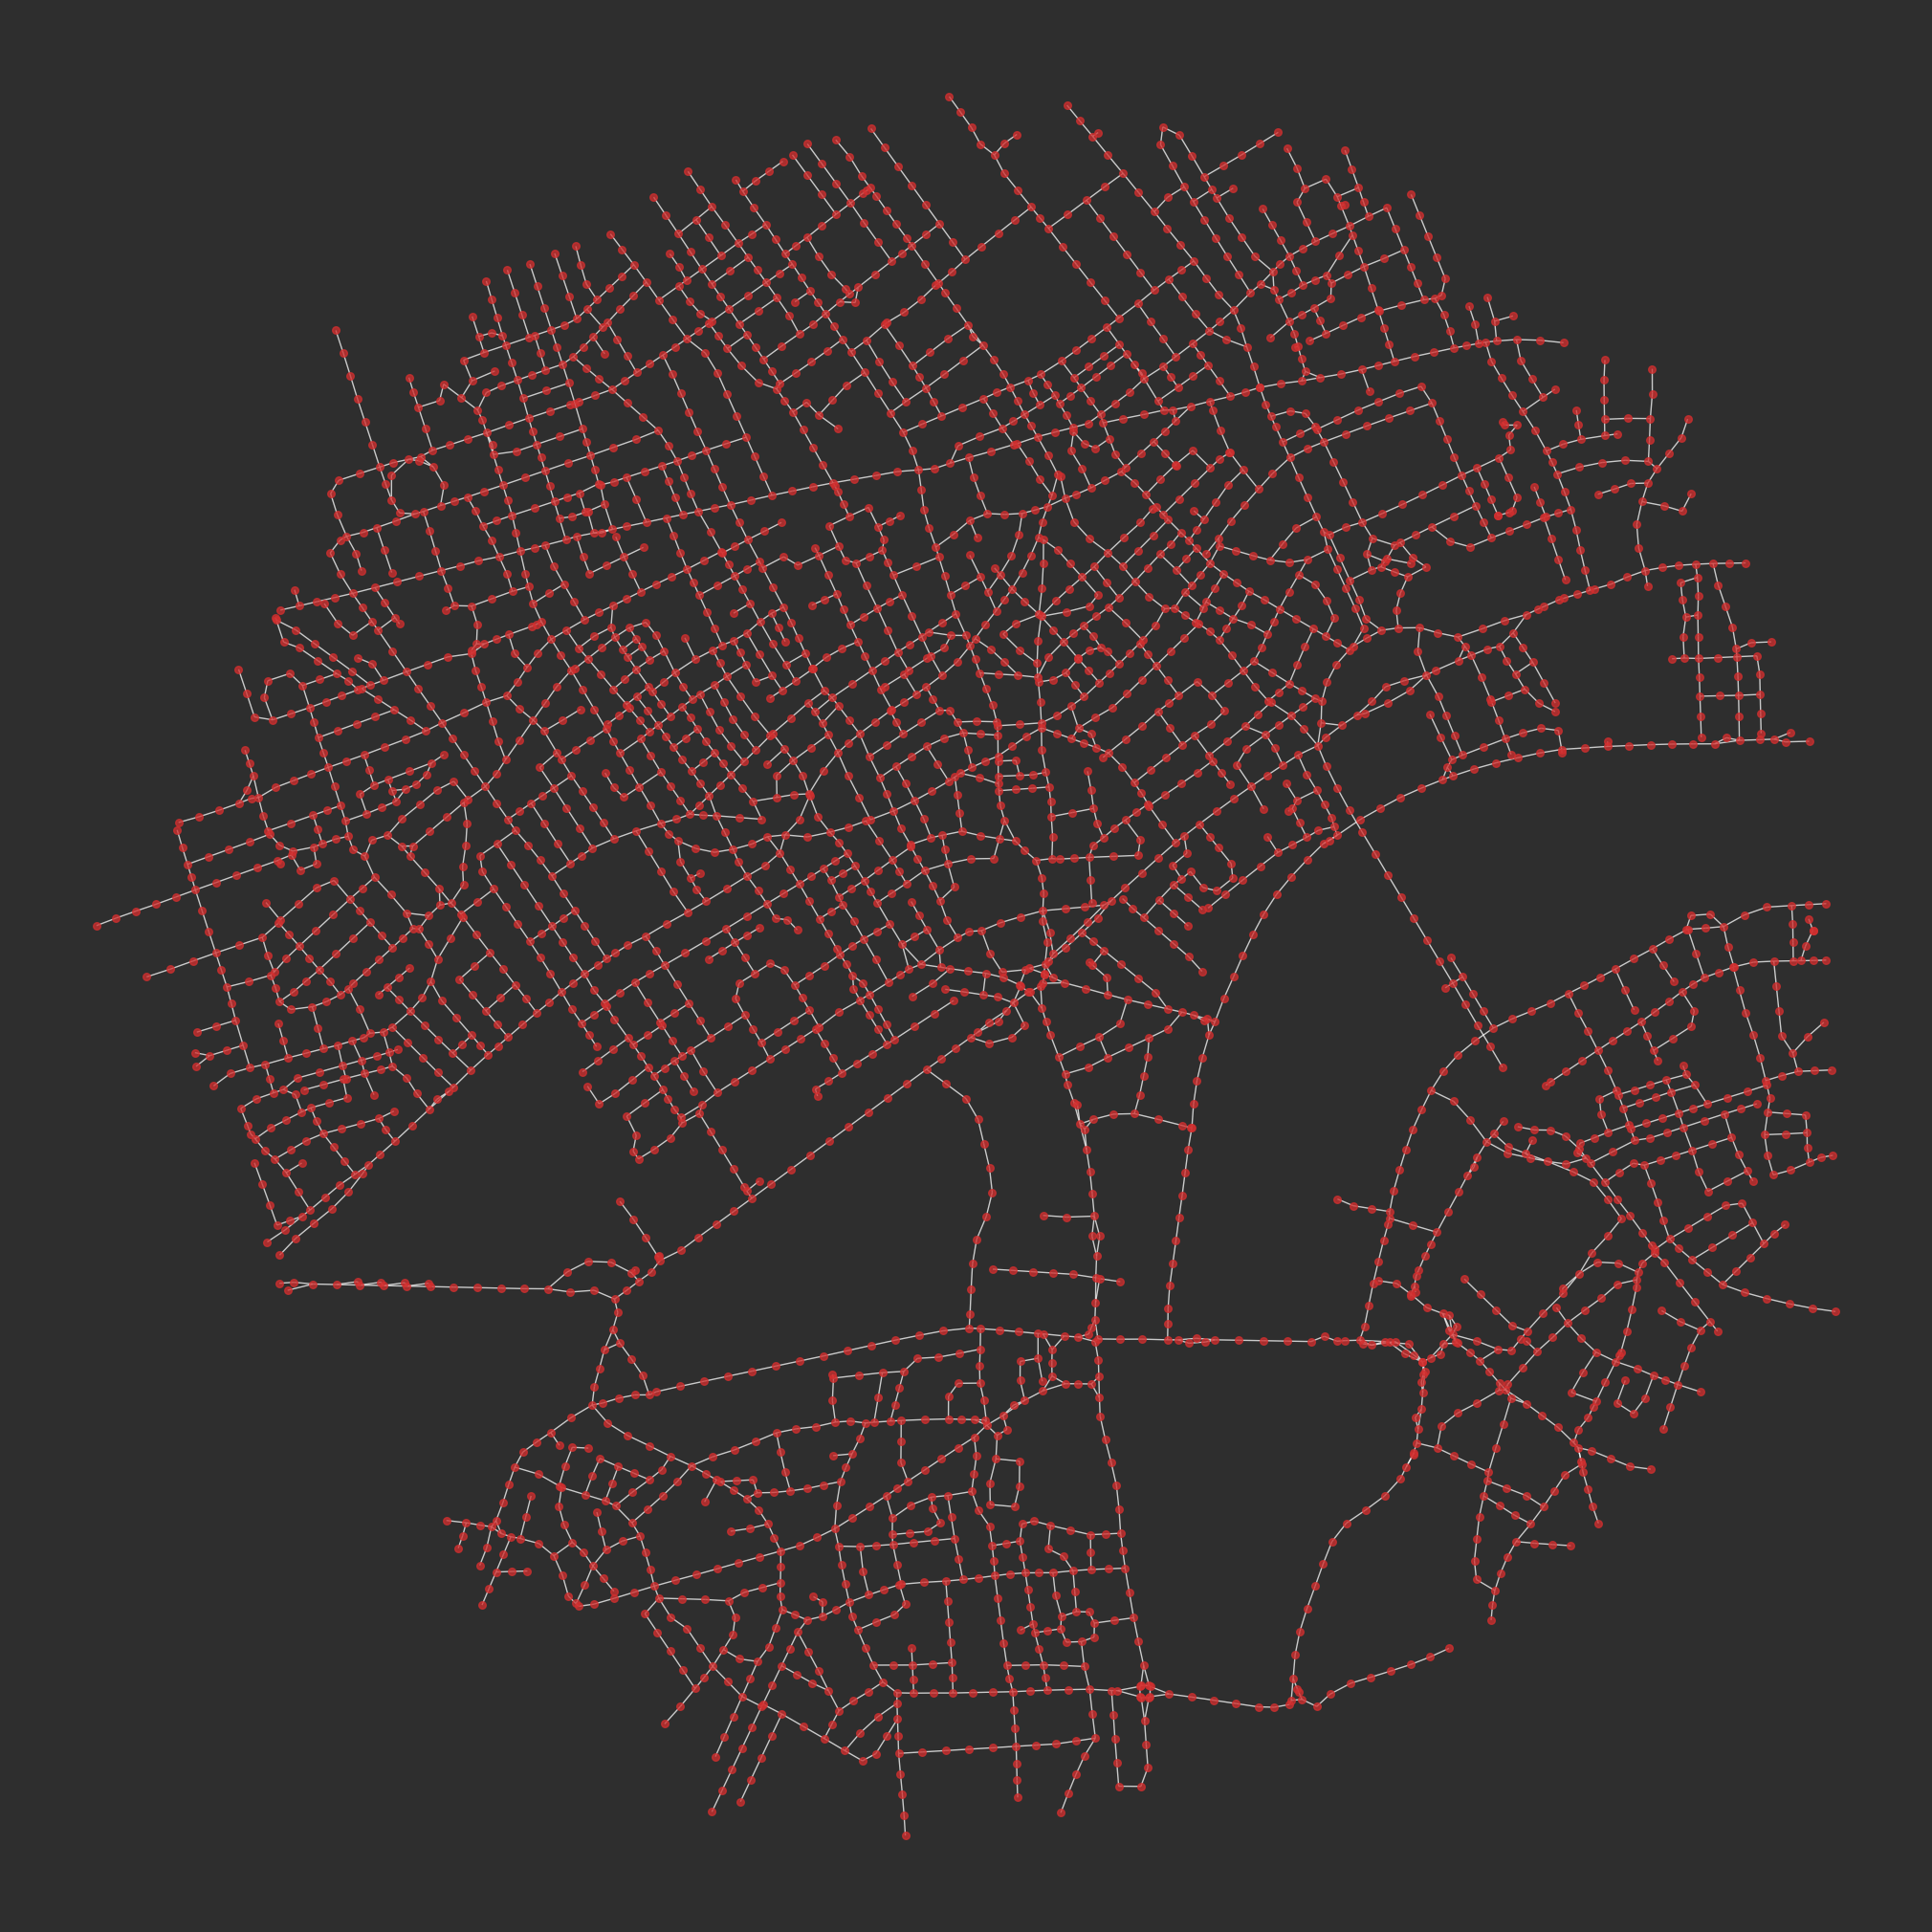

In [16]:
# decomposition of the network will even out the intensity of nodes
# set the decompose_max flag based on the level of granularity required
# decomposition can also be helpful in the graph cleaning process
G = graphs.nX_decompose(G, decompose_max=50)
# simplify split roadways
# some experimentation may be required to find the optimal buffer distance
# setting it too large, will deteriorate the quality of the network
G = graphs.nX_consolidate_parallel(G, buffer_dist=15)

plot.plot_nX(G, figsize=(20, 20), dpi=100)

There may still be locations that need some manual cleaning, though this is now much easier to accomplish. The graph is now ready for analysis with the `cityseer` package's methods.